In [3]:
from astropy.io import ascii, fits
import astropy
import pylab as plt
%matplotlib inline
from astropy import wcs
from astropy.table import Table,Column,join,hstack
from astropy.coordinates import SkyCoord
from astropy import units as u
import pymoc
import glob
from time import sleep
import os


import numpy as np
import xidplus
from xidplus import moc_routines
import pickle
import xidplus.catalogue as cat

import sys
from herschelhelp_internal.utils import inMoc,flux_to_mag
from xidplus.stan_fit import SPIRE

import aplpy
import seaborn as sns
#sns.set(color_codes=True)
import pandas as pd
#sns.set_style("white")
import xidplus.posterior_maps as postmaps
#from herschelhelp_internal.masterlist import merge_catalogues, nb_merge_dist_plot, specz_merge
#from herschelhelp import utils
import pyvo as vo
import time

In [4]:
masterlist = Table.read('../../../../../HELP/dmu_products/dmu32/dmu32_Bootes/data/Bootes_20190701_cigale.fits')

In [5]:
lofar = Table.read('data/data_release/final_cross_match_catalogue-v0.5.fits')
mask = (~np.isnan(lofar['F_SPIRE_250'])) | (~np.isnan(lofar['F_SPIRE_350'])) | (~np.isnan(lofar['F_SPIRE_500']))
lofar = lofar[~mask]

print(len(lofar))                  

4723


In [6]:
taskid = 1
batch_size = 20

if taskid*batch_size>len(lofar):
    print('Task id is too high. Trying to run code on more sources than exist')
    sys.exit()
ind_low = taskid*batch_size
if taskid*batch_size+batch_size>len(lofar):
    ind_up = len(lofar)
else:
    ind_up = taskid*batch_size+batch_size
ras = lofar['optRA'][ind_low:ind_up]
mask = np.isnan(ras)
ras[mask] = lofar['RA'][ind_low:ind_up][mask]

decs = lofar['optDec'][ind_low:ind_up]
mask = np.isnan(decs)
decs[mask] = lofar['DEC'][ind_low:ind_up][mask]

ids = lofar['Source_Name'][ind_low:ind_up]

In [7]:
len(ras)

20

In [8]:
source_use = [0,1,2,3,4,5,6,7,8,9]
ras = lofar['optRA'][source_use]
mask = np.isnan(ras)
ras[mask] = lofar['RA'][source_use][mask]

decs = lofar['optDec'][source_use]
mask = np.isnan(decs)
decs[mask] = lofar['DEC'][source_use][mask]

ids = lofar['Source_Name'][source_use]

In [9]:
imfolder='../../../../../HELP/dmu_products/dmu18/dmu18_HELP-PACS-maps/data/'

im100fits=imfolder + 'Bootes_PACS100_v0.9.fits'#PACS 100 map
im160fits=imfolder + 'Bootes_PACS160_v0.9.fits'#PACS 160 map

#-----100-------------
hdulist = fits.open(im100fits)
im100phdu=hdulist['PRIMARY'].header
im100=hdulist['IMAGE'].data*2.35045e-5*(np.abs(hdulist[1].header['CDELT1'])*3600)**2
hdulist['IMAGE'].header['BUNIT']='Jy/pix'
im100hdu=hdulist['IMAGE'].header

w_100 = wcs.WCS(hdulist['IMAGE'].header)
pixsize100=3600.0*np.abs(hdulist['IMAGE'].header['CDELT1']) #pixel size (in arcseconds)
nim100=hdulist['ERROR'].data*2.35045e-5*(np.abs(hdulist[1].header['CDELT1'])*3600)**2

hdulist.close()

#-----160-------------
hdulist = fits.open(im160fits)
im160phdu=hdulist['PRIMARY'].header
im160=hdulist['IMAGE'].data*2.35045e-5*(np.abs(hdulist[1].header['CDELT1'])*3600)**2
hdulist['IMAGE'].header['BUNIT']='Jy/pix'
im160hdu=hdulist['IMAGE'].header

w_160 = wcs.WCS(hdulist['IMAGE'].header)
pixsize160=3600.0*np.abs(hdulist['IMAGE'].header['CDELT1']) #pixel size (in arcseconds)
nim160=hdulist['ERROR'].data*2.35045e-5*(np.abs(hdulist[1].header['CDELT1'])*3600)**2
hdulist.close()

In [473]:
mask = nim100==1.0
masked_nim100 = nim100
masked_nim100[mask] = np.nan
bins = np.arange(0,6400,100)
avgs = np.zeros([64,64])
for n,edge_x in enumerate(bins):
    for m,edge_y in enumerate(bins):
        left = edge_x
        right = edge_x+100
        top = edge_y
        bot = edge_y+100
        avg = np.nansum(masked_nim100[left:right,top:bot])/(masked_nim100[left:right,top:bot].shape[0]*masked_nim100[left:right,top:bot].shape[1])
        print('average noise in map between pixel ({},{}) and pixel ({},{}) is: {}'.format(left,top,right,bot,avg))
        avgs[m,n] = avg

average noise in map between pixel (0,0) and pixel (100,100) is: 0.0
average noise in map between pixel (0,100) and pixel (100,200) is: 0.0
average noise in map between pixel (0,200) and pixel (100,300) is: 0.0
average noise in map between pixel (0,300) and pixel (100,400) is: 0.0
average noise in map between pixel (0,400) and pixel (100,500) is: 0.0
average noise in map between pixel (0,500) and pixel (100,600) is: 0.0
average noise in map between pixel (0,600) and pixel (100,700) is: 0.0
average noise in map between pixel (0,700) and pixel (100,800) is: 0.0
average noise in map between pixel (0,800) and pixel (100,900) is: 0.0
average noise in map between pixel (0,900) and pixel (100,1000) is: 0.0
average noise in map between pixel (0,1000) and pixel (100,1100) is: 0.0
average noise in map between pixel (0,1100) and pixel (100,1200) is: 0.0
average noise in map between pixel (0,1200) and pixel (100,1300) is: 0.0
average noise in map between pixel (0,1300) and pixel (100,1400) is: 0.0

average noise in map between pixel (2500,3200) and pixel (2600,3300) is: 0.00033934035301208494
average noise in map between pixel (2500,3300) and pixel (2600,3400) is: 0.0003415847301483154
average noise in map between pixel (2500,3400) and pixel (2600,3500) is: 0.0003455507278442383
average noise in map between pixel (2500,3500) and pixel (2600,3600) is: 0.000347266411781311
average noise in map between pixel (2500,3600) and pixel (2600,3700) is: 0.00034712250232696534
average noise in map between pixel (2500,3700) and pixel (2600,3800) is: 0.0003475003719329834
average noise in map between pixel (2500,3800) and pixel (2600,3900) is: 0.00034716029167175294
average noise in map between pixel (2500,3900) and pixel (2600,4000) is: 0.00034570701122283934
average noise in map between pixel (2500,4000) and pixel (2600,4100) is: 0.0003468355655670166
average noise in map between pixel (2500,4100) and pixel (2600,4200) is: 0.00034729084968566893
average noise in map between pixel (2500,4200)

average noise in map between pixel (5100,1300) and pixel (5200,1400) is: 0.000510588264465332
average noise in map between pixel (5100,1400) and pixel (5200,1500) is: 0.0005131123542785644
average noise in map between pixel (5100,1500) and pixel (5200,1600) is: 0.0005102992057800293
average noise in map between pixel (5100,1600) and pixel (5200,1700) is: 0.00050660982131958
average noise in map between pixel (5100,1700) and pixel (5200,1800) is: 0.0005101315021514893
average noise in map between pixel (5100,1800) and pixel (5200,1900) is: 0.000511606502532959
average noise in map between pixel (5100,1900) and pixel (5200,2000) is: 0.0005085551261901855
average noise in map between pixel (5100,2000) and pixel (5200,2100) is: 0.0005110569953918457
average noise in map between pixel (5100,2100) and pixel (5200,2200) is: 0.0005162003993988037
average noise in map between pixel (5100,2200) and pixel (5200,2300) is: 0.0005122561454772949
average noise in map between pixel (5100,2300) and pix

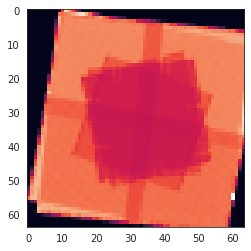

In [474]:
plt.imshow(avgs)

In [464]:
nim100[1000:1100,1000:1100]

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [10]:
prior_cat = Table.read('data/data_release/xidplus_prior_cat.fits')

In [11]:
from astropy.coordinates import SkyCoord
from astropy import units as u
c = SkyCoord(ra=ras*u.degree, dec=decs*u.degree)  
import pymoc
moc=pymoc.util.catalog.catalog_to_moc(c,60,15)

In [12]:
t1 = time.time()
#---prior100--------
prior100=xidplus.prior(im100,nim100,im100phdu,im100hdu, moc=moc)#Initialise with map, uncertianty map, wcs info and primary header
prior100.prior_cat(prior_cat['ra'],prior_cat['dec'],'prior_cat',ID=prior_cat['help_id'])#Set input catalogue
prior100.prior_bkg(0.0,5)#Set prior on background (assumes Gaussian pdf with mu and sigma)

#---prior160--------
prior160=xidplus.prior(im160,nim160,im160phdu,im160hdu, moc=moc)
prior160.prior_cat(prior_cat['ra'],prior_cat['dec'],'prior_cat',ID=prior_cat['help_id'])
prior160.prior_bkg(0.0,5)
t2 = time.time()
print('time taken is: {}s'.format(t2-t1))

time taken is: 198.700421333313s


In [13]:
pacs100_psf=fits.open('../../../../../HELP/dmu_products/dmu18/dmu18_Bootes/data/dmu18_PACS_100_PSF_Bootes_20190125.fits')
pacs160_psf=fits.open('../../../../../HELP/dmu_products/dmu18/dmu18_Bootes/data/dmu18_PACS_160_PSF_Bootes_20190125.fits')


centre100=np.long((pacs100_psf[1].header['NAXIS1']-1)/2)
radius100=15
centre160=np.long((pacs160_psf[1].header['NAXIS1']-1)/2)
radius160=15

pind100=np.arange(0,radius100+1+radius100,1)*3600*np.abs(pacs100_psf[1].header['CDELT1'])/pixsize100 #get 100 scale in terms of pixel scale of map
pind160=np.arange(0,radius160+1+radius160,1)*3600*np.abs(pacs160_psf[1].header['CDELT1'])/pixsize160 #get 160 scale in terms of pixel scale of map



prior100.set_prf(pacs100_psf[1].data[centre100-radius100:centre100+radius100+1,centre100-radius100:centre100+radius100+1]/1000.0,
                pind100,pind100)
prior160.set_prf(pacs160_psf[1].data[centre160-radius160:centre160+radius160+1,centre160-radius160:centre160+radius160+1]/1000.0,
                pind160,pind160)

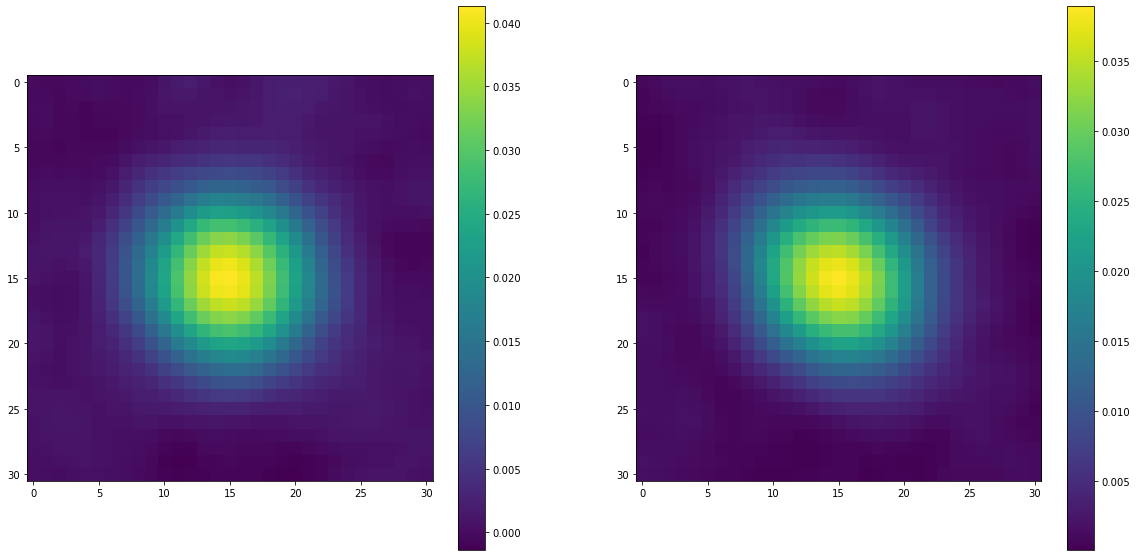

In [14]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(pacs100_psf[1].data[centre100-radius100:centre100+radius100+1,centre100-radius100:centre100+radius100+1])
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(pacs160_psf[1].data[centre160-radius160:centre160+radius160+1,centre160-radius160:centre160+radius160+1])
plt.colorbar()

In [15]:
print('fitting '+ str(prior100.nsrc)+' sources \n')
print('using ' +  str(prior100.snpix)+', '+ str(prior160.snpix))



fitting 69 sources 

using 21098, 9376


In [16]:
prior100.get_pointing_matrix()
prior160.get_pointing_matrix()

In [20]:
from xidplus.numpyro_fit import PACS
t1 = time.time()
fit=PACS.all_bands([prior100,prior160])
t2 = time.time()
print('time taken is: {}s'.format(t2-t1))

time taken is: 473.1776223182678s


In [21]:
posterior=xidplus.posterior_numpyro(fit,[prior100,prior160])

Number of divergences: 0


In [22]:
priors = [prior100,prior160]

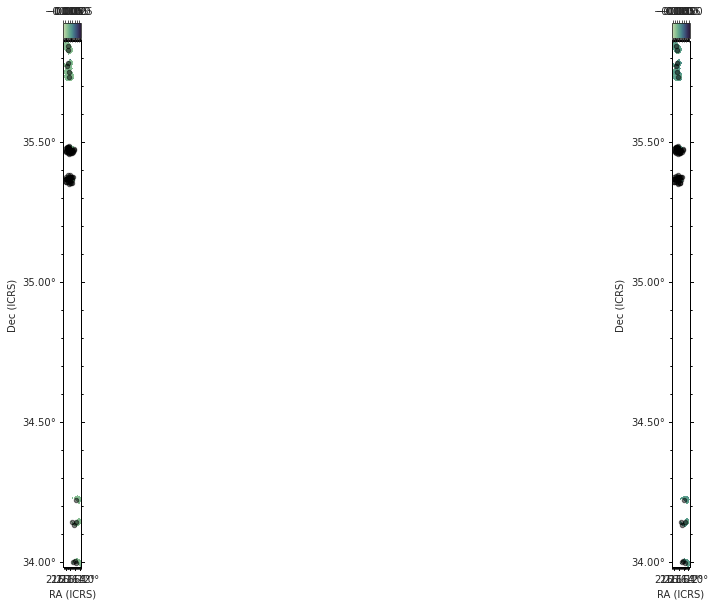

In [23]:
figs,fig=xidplus.plot_map(priors)

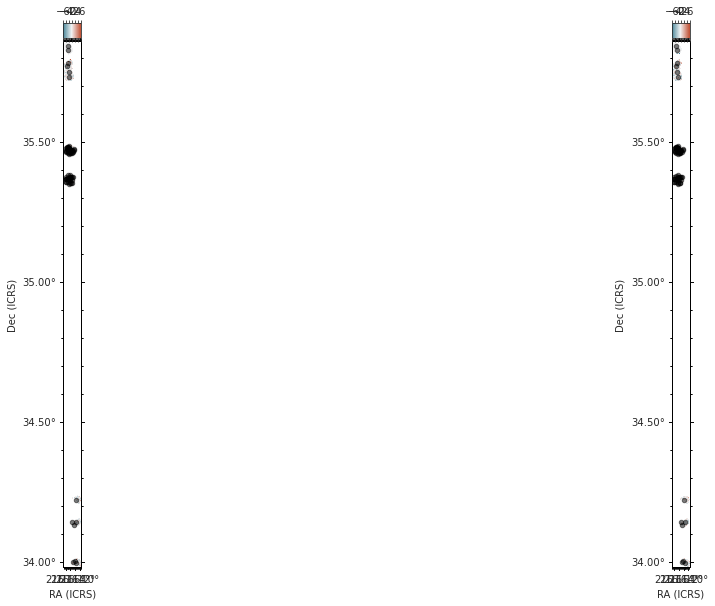

In [24]:
figs, fig=xidplus.plot_Bayes_pval_map(priors, posterior)

In [25]:
import xidplus.catalogue as cat
PACS_cat=cat.create_PACS_cat(posterior,priors[0],priors[1])

In [440]:
st.norm.ppf(0.16)

-0.994457883209753

In [417]:
__author__ = 'pdh21'
from astropy.io import fits
import scipy.stats as st
import numpy as np
from astropy.io import fits


def ymod_map(prior,flux):
    """Create replicated model map (no noise or background) i.e. A*f

    :param prior: xidplus.prior class
    :param flux: flux vector
    :return: map array, in same format as prior.sim
    """
    from scipy.sparse import coo_matrix

    f=coo_matrix((flux, (range(0,prior.nsrc),np.zeros(prior.nsrc))), shape=(prior.nsrc, 1))
    A=coo_matrix((prior.amat_data, (prior.amat_row, prior.amat_col)), shape=(prior.snpix, prior.nsrc))
    rmap_temp=(A*f)
    return np.asarray(rmap_temp.todense())


def Bayesian_pvals(prior,post_rep_map):
    """Get Bayesian P values for each pixel

    :param prior: xidplus.prior class
    :param post_rep_map: posterior replicated maps
    :return: Bayesian P values
    """
    pval=np.empty_like(prior.sim)
    for i in range(0,prior.snpix):
        ind=post_rep_map[i,:]<prior.sim[i]
        pval[i]=sum(ind)/np.float(post_rep_map.shape[1])
    pval[np.isposinf(pval)]=1.0
    #pval[np.isneginf(pval)]=0.0
    return pval

def make_Bayesian_pval_maps(prior,post_rep_map):
    """Bayesian P values, quoted as sigma level

    :param prior: xidplus.prior class
    :param post_rep_map: posterior replicated maps
    :return: Bayesian P values converted to sigma level
    """
    pval=Bayesian_pvals(prior,post_rep_map)
    for i in range(0,prior.snpix):
        pval[i]=st.norm.ppf(pval[i])
    pval[np.isposinf(pval)]=6.0
    pval[np.isneginf(pval)]=-6.0
    return pval


def Bayes_Pval_res(prior,post_rep_map):
    """The local Bayesian P value residual statistic. 
    
    
    :param prior: xidplus.prior class
    :param post_rep_map: posterior replicated maps
    :return: Bayesian P value residual statistic for each source
    """
    Bayes_pval_res_vals=np.empty((prior.nsrc))
    for i in range(0,prior.nsrc):
        ind= prior.amat_col == i
        t = np.sum(((post_rep_map[prior.amat_row[ind], :] - prior.sim[prior.amat_row[ind], None]) / (
        np.sqrt(2) * prior.snim[prior.amat_row[ind], None])) ** 2.0, axis=0)
        #print(t)
        ind_T = t / ind.sum() > 2
        #print(ind_T)
        #print(len(ind_T))
        Bayes_pval_res_vals[i] = ind_T.sum()/np.float(post_rep_map.shape[1])


    return Bayes_pval_res_vals



def make_fits_image(prior,pixel_values):
    """Make FITS image realting to map in xidplus.prior class
    :param prior: xidplus.prior class
    :param pixel_values: pixel values in format of xidplus.prior.sim
    :return: FITS hdulist
    """
    x_range=np.max(prior.sx_pix)-np.min(prior.sx_pix)
    y_range=np.max(prior.sy_pix)-np.min(prior.sy_pix)
    data=np.full((y_range,x_range),np.nan)
    data[prior.sy_pix-np.min(prior.sy_pix)-1,prior.sx_pix-np.min(prior.sx_pix)-1]=pixel_values
    hdulist = fits.HDUList([fits.PrimaryHDU(header=prior.imphdu),fits.ImageHDU(data=data,header=prior.imhdu)])
    hdulist[1].header['CRPIX1']=hdulist[1].header['CRPIX1']-np.min(prior.sx_pix)-1
    hdulist[1].header['CRPIX2']=hdulist[1].header['CRPIX2']-np.min(prior.sy_pix)-1

    return hdulist

def replicated_maps(priors,posterior,nrep=1000):
    """Create posterior replicated maps

    :param priors: list of xidplus.prior class
    :param posterior: xidplus.posterior class
    :param nrep: number of replicated maps
    :return: 
    """
    mod_map_array=list(map(lambda prior:np.empty((prior.snpix,nrep)), priors))
    for i in range(0,nrep):
        try:
            for b in range(0,len(priors)):
                mod_map_array[b][:,i]= ymod_map(priors[b],posterior.samples['src_f'][i,b,:]).reshape(-1)\
                                       +posterior.samples['bkg'][i,b]\
                                       +np.random.normal(scale=np.sqrt(priors[b].snim**2
                                                                       +posterior.samples['sigma_conf'][i,b]**2))
        except IndexError:
            for b in range(0,len(priors)):
                mod_map_array[b][:,i]= ymod_map(priors[b],posterior.samples['src_f'][i,b,:]).reshape(-1)\
                                       +posterior.samples['bkg'][i]\
                                       +np.random.normal(scale=np.sqrt(priors[b].snim**2
                                                                       +posterior.samples['sigma_conf'][i]**2))
    return mod_map_array

In [418]:
PACS_cat = Table.read(PACS_cat)

In [419]:
PACS_cat

help_id,RA,Dec,F_PACS_100,FErr_PACS_100_u,FErr_PACS_100_l,F_PACS_160,FErr_PACS_160_u,FErr_PACS_160_l,Bkg_PACS_100,Bkg_PACS_160,Sig_conf_PACS_100,Sig_conf_PACS_160,Rhat_PACS_100,Rhat_PACS_160,n_eff_PACS_100,n_eff_PACS_160,Pval_res_100,Pval_res_160
,degrees,degrees,mJy,mJy,mJy,mJy,mJy,mJy,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,,,,,,
str27,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
HELP_J143009.048+350011.462,217.53770045616199,35.003184027634,3.8997886,8.108246,1.2800778,2.902626,6.884261,0.71761173,0.0003969688,0.0006104748,0.00047373673,0.00044257462,0.99931055,1.0019182,2079.0632,2116.352,0.988,0.066
HELP_J143009.502+350014.936,217.53959315616197,35.004148827634005,2.1218457,4.9990377,0.5439588,1.5171323,4.0564322,0.36463636,0.0003969688,0.0006104748,0.00047373673,0.00044257462,0.9990541,0.9989334,1947.6562,2878.9177,0.997,0.057
HELP_J143009.527+350038.215,217.53969695616198,35.010615227634,1.1115977,2.9694626,0.27695146,2.9264488,7.123649,0.7587203,0.0003969688,0.0006104748,0.00047373673,0.00044257462,0.99888164,1.0007622,3033.1792,2268.1086,0.997,0.163
HELP_J143010.014+350042.098,217.54172332979252,35.011693835653816,1.1164033,2.8085732,0.26249656,8.867736,15.348913,3.3246846,0.0003969688,0.0006104748,0.00047373673,0.00044257462,0.999291,0.9992714,2615.9346,1320.4126,1.0,0.179
HELP_J143010.909+350038.688,217.5454548921625,35.01074663834955,0.816855,2.07567,0.19516306,4.6697316,9.972882,1.3565184,0.0003969688,0.0006104748,0.00047373673,0.00044257462,0.9982326,1.0003303,2247.0938,1893.9967,0.999,0.111
HELP_J143011.538+350010.853,217.54807475616198,35.003014627634,5.841038,10.83538,2.076154,7.9093723,14.17615,2.98825,0.0003969688,0.0006104748,0.00047373673,0.00044257462,0.99907315,0.99873954,2410.7998,2012.0201,0.976,0.163
HELP_J143011.558+350020.485,217.54815965616197,35.005690227634,6.0363092,11.321479,2.0133038,3.7470148,8.174311,1.1302761,0.0003969688,0.0006104748,0.00047373673,0.00044257462,1.0019476,1.0023,1682.6779,2079.4614,0.999,0.152
HELP_J143012.406+345950.811,217.551691956162,34.997447627634,24.965487,30.056038,19.679018,24.65266,31.532463,17.447313,0.0003969688,0.0006104748,0.00047373673,0.00044257462,1.0017005,0.99871874,1345.9097,2775.6494,0.999,0.097


In [160]:
mask = [PACS_cat['help_id'][i] in ids for i in range(len(PACS_cat))]
#mask2 = ['ILTJ' in ]
PACS_cat[mask]

help_id,RA,Dec,F_PACS_100,FErr_PACS_100_u,FErr_PACS_100_l,F_PACS_160,FErr_PACS_160_u,FErr_PACS_160_l,Bkg_PACS_100,Bkg_PACS_160,Sig_conf_PACS_100,Sig_conf_PACS_160,Rhat_PACS_100,Rhat_PACS_160,n_eff_PACS_100,n_eff_PACS_160,Pval_res_100,Pval_res_160
,degrees,degrees,mJy,mJy,mJy,mJy,mJy,mJy,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,,,,,,
str27,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
ILTJ143546.91+340710.2,218.9453963,34.1196707,4.5946813,9.886977,1.3679105,10.444738,20.63464,3.524534,0.00044802693,0.0005444917,0.0007557246,0.00086015166,1.0001895,1.0124949,1323.4165,308.83484,1.0,0.954
ILTJ143547.20+342312.7,218.9465948,34.3868882,7.9124246,16.024342,2.4074626,3.7264912,9.066699,0.84887123,0.00044802693,0.0005444917,0.0007557246,0.00086015166,1.0075264,1.007288,327.1967,769.7615,1.0,0.981
ILTJ143547.62+333947.2,218.948869,33.6633149,6.6994896,13.058979,2.3275971,15.142339,24.937323,6.327592,0.00044802693,0.0005444917,0.0007557246,0.00086015166,0.99957806,1.0038592,1399.0785,706.02875,1.0,0.696
ILTJ143548.40+353611.3,218.9516467,35.6035367,1.4419061,3.5551624,0.37327397,3.141681,7.614704,0.85044646,0.00044802693,0.0005444917,0.0007557246,0.00086015166,1.0039392,0.99951947,1137.1681,1158.0702,1.0,0.956
ILTJ143548.41+330504.6,218.9518163,33.0847346,2.4632354,6.027158,0.663936,20.60217,38.37843,5.597467,0.00044802693,0.0005444917,0.0007557246,0.00086015166,1.0014378,1.0151448,1331.768,263.9089,1.0,0.985
ILTJ143548.42+343351.1,218.9519236,34.5638297,4.6321,11.135181,1.2707307,12.905428,25.399635,4.675649,0.00044802693,0.0005444917,0.0007557246,0.00086015166,1.0054244,1.0072353,502.84402,510.37347,1.0,0.903
ILTJ143548.64+350602.7,218.9535332,35.1008829,23.970295,31.509857,16.968918,11.76873,21.021648,4.100493,0.00044802693,0.0005444917,0.0007557246,0.00086015166,1.0037307,1.0035903,400.58197,605.4451,1.0,0.886
ILTJ143548.88+344934.5,218.9536247,34.8263086,11.55281,18.993294,5.2667947,6.3075843,13.524207,1.7521724,0.00044802693,0.0005444917,0.0007557246,0.00086015166,1.0026069,1.0064114,891.0553,669.24884,1.0,0.972


In [158]:
joined = join(PACS_cat,masterlist,join_type='inner',keys='help_id')

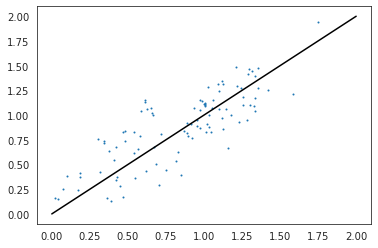

In [159]:
x = np.log10(joined['f_pacs_green'])-3
xerr = np.log10(joined['ferr_pacs_green'])-3
y = np.log10(joined['F_PACS_100'])
yerr_u = np.log10(joined['FErr_PACS_100_u'])
yerr_l = np.log10(joined['FErr_PACS_100_l'])

#plt.errorbar(x,y,xerr=xerr,yerr=[yerr_u,yerr_l])
plt.scatter(x,y,s=1)
plt.plot([0,2],[0,2],c='black')

plt.show()

In [140]:
mask = 'ILTJ' in SPIRE_cat['HELP_ID']
mask_lofar = lofar['ra']==ra
mask_pcat = prior_cat['help_id']=='lofar'
SPIRE_cat = SPIRE_cat[mask]
SPIRE_cat.add_columns([prior_cat['f_mips_24'][mask_pcat],prior_cat['flag_optnir_det'][mask_pcat]])
lofar_fir = hstack([lofar[mask_lofar],SPIRE_cat])
XID_rerun_col = Column(data=XID_rerun,name='XID_rerun',dtype=bool)
source_type_col = Column(data=source_type,name='source_type',dtype=str)
lofar_fir.add_columns([XID_rerun_col,source_type_col])
    
#os.mkdir('testfolder')
#Table.write(lofar_fir,'testfolder/lofar_xidplus_fir.fits')

In [141]:
lofar_fir

Source_id,Isl_id,RA_1,E_RA,DEC,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,RA_max,E_RA_max,DEC_max,E_DEC_max,Maj,E_Maj,Min,E_Min,PA,E_PA,Maj_img_plane,E_Maj_img_plane,Min_img_plane,E_Min_img_plane,PA_img_plane,E_PA_img_plane,DC_Maj,E_DC_Maj,DC_Min,E_DC_Min,DC_PA,E_DC_PA,DC_Maj_img_plane,E_DC_Maj_img_plane,DC_Min_img_plane,E_DC_Min_img_plane,DC_PA_img_plane,E_DC_PA_img_plane,Isl_Total_flux,E_Isl_Total_flux,Isl_rms,Isl_mean,Resid_Isl_rms,Resid_Isl_mean,S_Code,FLAG_OVERLAP_1,lr_fin,lr_dist_fin,lr_index_fin,fworkflow_all,FLAG_WORKFLOW,NUMBER,SNR_WIN,BACKGROUND,THRESHOLD,X_IMAGE,Y_IMAGE,ra,dec,X2_IMAGE,Y2_IMAGE,XY_IMAGE,X2_WORLD,Y2_WORLD,A_IMAGE,B_IMAGE,THETA_IMAGE,ERRA_IMAGE,ERRB_IMAGE,ERRTHETA_IMAGE,FLAGS_i,CLASS_STAR,FLAGS_J,FLAGS_K,FLAGS_g,FLAGS_hscg,FLAGS_hsci,FLAGS_hscnb921,FLAGS_hscr,FLAGS_hscy,FLAGS_hscz,FLAGS_r,FLAGS_se1,FLAGS_se2,FLAGS_sw1,FLAGS_sw2,FLAGS_sw3,FLAGS_sw4,FLAGS_u,FLAGS_y,FLAGS_z,flag_clean,NUMBER_OPTICAL,NUMBER_SPITZER,MAG_APER_sw4_1,MAG_APER_sw4_2,MAG_APER_sw4_3,MAG_APER_sw4_4,MAG_APER_sw4_5,MAG_APER_sw4_6,MAG_APER_sw4_7,MAG_APER_sw4_10,MAGERR_APER_sw4_1,MAGERR_APER_sw4_2,MAGERR_APER_sw4_3,MAGERR_APER_sw4_4,MAGERR_APER_sw4_5,MAGERR_APER_sw4_6,MAGERR_APER_sw4_7,MAGERR_APER_sw4_10,FLUX_APER_sw4_1,FLUX_APER_sw4_2,FLUX_APER_sw4_3,FLUX_APER_sw4_4,FLUX_APER_sw4_5,FLUX_APER_sw4_6,FLUX_APER_sw4_7,FLUX_APER_sw4_10,FLUXERR_APER_sw4_1,FLUXERR_APER_sw4_2,FLUXERR_APER_sw4_3,FLUXERR_APER_sw4_4,FLUXERR_APER_sw4_5,FLUXERR_APER_sw4_6,FLUXERR_APER_sw4_7,FLUXERR_APER_sw4_10,MAG_APER_sw1_1,MAG_APER_sw1_2,MAG_APER_sw1_3,MAG_APER_sw1_4,MAG_APER_sw1_5,MAG_APER_sw1_6,MAG_APER_sw1_7,MAG_APER_sw1_10,MAGERR_APER_sw1_1,MAGERR_APER_sw1_2,MAGERR_APER_sw1_3,MAGERR_APER_sw1_4,MAGERR_APER_sw1_5,MAGERR_APER_sw1_6,MAGERR_APER_sw1_7,MAGERR_APER_sw1_10,FLUX_APER_sw1_1,FLUX_APER_sw1_2,FLUX_APER_sw1_3,FLUX_APER_sw1_4,FLUX_APER_sw1_5,FLUX_APER_sw1_6,FLUX_APER_sw1_7,FLUX_APER_sw1_10,FLUXERR_APER_sw1_1,FLUXERR_APER_sw1_2,FLUXERR_APER_sw1_3,FLUXERR_APER_sw1_4,FLUXERR_APER_sw1_5,FLUXERR_APER_sw1_6,FLUXERR_APER_sw1_7,FLUXERR_APER_sw1_10,MAG_APER_sw3_1,MAG_APER_sw3_2,MAG_APER_sw3_3,MAG_APER_sw3_4,MAG_APER_sw3_5,MAG_APER_sw3_6,MAG_APER_sw3_7,MAG_APER_sw3_10,MAGERR_APER_sw3_1,MAGERR_APER_sw3_2,MAGERR_APER_sw3_3,MAGERR_APER_sw3_4,MAGERR_APER_sw3_5,MAGERR_APER_sw3_6,MAGERR_APER_sw3_7,MAGERR_APER_sw3_10,FLUX_APER_sw3_1,FLUX_APER_sw3_2,FLUX_APER_sw3_3,FLUX_APER_sw3_4,FLUX_APER_sw3_5,FLUX_APER_sw3_6,FLUX_APER_sw3_7,FLUX_APER_sw3_10,FLUXERR_APER_sw3_1,FLUXERR_APER_sw3_2,FLUXERR_APER_sw3_3,FLUXERR_APER_sw3_4,FLUXERR_APER_sw3_5,FLUXERR_APER_sw3_6,FLUXERR_APER_sw3_7,FLUXERR_APER_sw3_10,MAG_APER_sw2_1,MAG_APER_sw2_2,MAG_APER_sw2_3,MAG_APER_sw2_4,MAG_APER_sw2_5,MAG_APER_sw2_6,MAG_APER_sw2_7,MAG_APER_sw2_10,MAGERR_APER_sw2_1,MAGERR_APER_sw2_2,MAGERR_APER_sw2_3,MAGERR_APER_sw2_4,MAGERR_APER_sw2_5,MAGERR_APER_sw2_6,MAGERR_APER_sw2_7,MAGERR_APER_sw2_10,FLUX_APER_sw2_1,FLUX_APER_sw2_2,FLUX_APER_sw2_3,FLUX_APER_sw2_4,FLUX_APER_sw2_5,FLUX_APER_sw2_6,FLUX_APER_sw2_7,FLUX_APER_sw2_10,FLUXERR_APER_sw2_1,FLUXERR_APER_sw2_2,FLUXERR_APER_sw2_3,FLUXERR_APER_sw2_4,FLUXERR_APER_sw2_5,FLUXERR_APER_sw2_6,FLUXERR_APER_sw2_7,FLUXERR_APER_sw2_10,MAG_APER_se2_1,MAG_APER_se2_2,MAG_APER_se2_3,MAG_APER_se2_4,MAG_APER_se2_5,MAG_APER_se2_6,MAG_APER_se2_7,MAG_APER_se2_10,MAGERR_APER_se2_1,MAGERR_APER_se2_2,MAGERR_APER_se2_3,MAGERR_APER_se2_4,MAGERR_APER_se2_5,MAGERR_APER_se2_6,MAGERR_APER_se2_7,MAGERR_APER_se2_10,FLUX_APER_se2_1,FLUX_APER_se2_2,FLUX_APER_se2_3,FLUX_APER_se2_4,FLUX_APER_se2_5,FLUX_APER_se2_6,FLUX_APER_se2_7,FLUX_APER_se2_10,FLUXERR_APER_se2_1,FLUXERR_APER_se2_2,FLUXERR_APER_se2_3,FLUXERR_APER_se2_4,FLUXERR_APER_se2_5,FLUXERR_APER_se2_6,FLUXERR_APER_se2_7,FLUXERR_APER_se2_10,MAG_APER_se1_1,MAG_APER_se1_2,MAG_APER_se1_3,MAG_APER_se1_4,MAG_APER_se1_5,MAG_APER_se1_6,MAG_APER_se1_7,MAG_APER_se1_10,MAGERR_APER_se1_1,MAGERR_APER_se1_2,MAGERR_APER_se1_3,MAGERR_APER_se1_4,MAGERR_APER_se1_5,MAGERR_APER_se1_6,MAGERR_APER_se1_7,MAGERR_APER_se1_10,FLUX_APER_se1_1,FLUX_APER_se1_2,FL

In [147]:
os.path.exists('data/fir_v2/xidplus_run_3')

True

In [225]:
priors_spire,posterior_spire = xidplus.load('data/fir/SPIRE/xidplus_run_3/lofar_xidplus_fir_3_rerun.pkl')

In [226]:
rep_map_spire = replicated_maps(priors_spire,posterior_spire)

In [228]:
np.sum( ((priors_spire[0].sim - rep_map_spire[0][:,0])/(np.sqrt(2) * priors_spire[0].snim))**2 ) 

3753.249317829779

In [231]:
Bayes_Pval_res(priors_spire[0],rep_map_spire[0])

array([0.002, 0.   , 0.   , 0.007, 0.001, 0.   , 0.   , 0.   , 0.003,
       0.   , 0.004, 0.   , 0.003, 0.   , 0.028, 0.   , 0.   , 0.023,
       0.   , 0.   , 0.   , 0.001, 0.   , 0.   , 0.   , 0.001, 0.   ,
       0.   , 0.   , 0.002, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.029, 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.001, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.001,
       0.   , 0.001, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.205, 0.   , 0.   , 0.002, 0.001, 0.002,
       0.003, 0.   , 0.   , 0.   , 0.   , 0.   , 0.001, 0.   , 0.   ,
       0.003, 0.   , 0.   , 0.002, 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.002, 0.   , 0.   , 0.   , 0.   , 0.   , 0.001, 0.145,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.049, 0.   , 0.046, 0.   ,
       0.   , 0.053,

In [303]:
f = open('../../../../../HELP/dmu_products/dmu26/dmu26_XID+PACS_Bootes/data/pkl_list.txt','r')
lines = []
for line in f:
    lines.append(f.readline())

tiles = []
for line in lines:
    line = line.split('_')
    print(line)
    healpixid = int(line[1])
    tiles.append(healpixid)
'''    try:
        healpixid = int(line[5:13])
    except:
        continue
    tiles.append(healpixid)'''

['Tile', '10753346', '11.pkl\n']
['Tile', '10753348', '11.pkl\n']
['Tile', '10753350', '11.pkl\n']
['Tile', '10753353', '11.pkl\n']
['Tile', '10753356', '11.pkl\n']
['Tile', '10753358', '11.pkl\n']
['Tile', '10753360', '11.pkl\n']
['Tile', '10753362', '11.pkl\n']
['Tile', '10753364', '11.pkl\n']
['Tile', '10753366', '11.pkl\n']
['Tile', '10753368', '11.pkl\n']
['Tile', '10753370', '11.pkl\n']
['Tile', '10753372', '11.pkl\n']
['Tile', '10753374', '11.pkl\n']
['Tile', '10753381', '11.pkl\n']
['Tile', '10753389', '11.pkl\n']
['Tile', '10753393', '11.pkl\n']
['Tile', '10753395', '11.pkl\n']
['Tile', '10753397', '11.pkl\n']
['Tile', '10753399', '11.pkl\n']
['Tile', '10753401', '11.pkl\n']
['Tile', '10753403', '11.pkl\n']
['Tile', '10753405', '11.pkl\n']
['Tile', '10753407', '11.pkl\n']
['Tile', '10753492', '11.pkl\n']
['Tile', '10753494', '11.pkl\n']
['Tile', '10753501', '11.pkl\n']
['Tile', '10764288', '11.pkl\n']
['Tile', '10764290', '11.pkl\n']
['Tile', '10764292', '11.pkl\n']
['Tile', '

['Tile', '9366689', '11.pkl\n']
['Tile', '9366691', '11.pkl\n']
['Tile', '9366693', '11.pkl\n']
['Tile', '9366695', '11.pkl\n']
['Tile', '9366697', '11.pkl\n']
['Tile', '9366699', '11.pkl\n']
['Tile', '9366701', '11.pkl\n']
['Tile', '9366703', '11.pkl\n']
['Tile', '9366705', '11.pkl\n']
['Tile', '9366707', '11.pkl\n']
['Tile', '9366709', '11.pkl\n']
['Tile', '9366711', '11.pkl\n']
['Tile', '9366713', '11.pkl\n']
['Tile', '9366715', '11.pkl\n']
['Tile', '9366717', '11.pkl\n']
['Tile', '9366719', '11.pkl\n']
['Tile', '9366721', '11.pkl\n']
['Tile', '9366723', '11.pkl\n']
['Tile', '9366725', '11.pkl\n']
['Tile', '9366727', '11.pkl\n']
['Tile', '9366729', '11.pkl\n']
['Tile', '9366731', '11.pkl\n']
['Tile', '9366733', '11.pkl\n']
['Tile', '9366735', '11.pkl\n']
['Tile', '9366737', '11.pkl\n']
['Tile', '9366739', '11.pkl\n']
['Tile', '9366741', '11.pkl\n']
['Tile', '9366743', '11.pkl\n']
['Tile', '9366745', '11.pkl\n']
['Tile', '9366747', '11.pkl\n']
['Tile', '9366749', '11.pkl\n']
['Tile',

IndexError: list index out of range

In [313]:
ras = prior100.sra
decs = prior100.sdec

file = []
for n,ra in enumerate(ras):
    #print(ras[n],decs[n])
    for tile in tiles:
        #print(np.array(ras[n]))
        print(xidplus.moc_routines.sources_in_tile([healpixid],11,np.array([ras[n],0]),np.array([decs[n],0])))
        if xidplus.moc_routines.sources_in_tile([healpixid],11,np.array([ras[n],0]),np.array([decs[n],0]))[0]==True:
            file.append(tile)

[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, Fa

[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, Fa

[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, Fa

[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, Fa

[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, Fa

[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, Fa

[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, Fa

[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, Fa

[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, Fa

[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, Fa

[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, Fa

[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, Fa

[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, Fa

[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, Fa

[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, Fa

[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, Fa

[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, Fa

[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, Fa

[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, Fa

[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, Fa

[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, Fa

[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, Fa

[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, Fa

[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, Fa

[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, Fa

[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, Fa

[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, Fa

[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, Fa

[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, Fa

[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, Fa

[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, Fa

[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, Fa

[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, Fa

[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, Fa

[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, Fa

[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, Fa

[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, Fa

[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, Fa

[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, Fa

[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, Fa

[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, Fa

[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, Fa

[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, Fa

[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, Fa

[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, Fa

[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, Fa

[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, Fa

[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, Fa

[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, Fa

[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, Fa

[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, False]
[False, Fa

KeyboardInterrupt: 

In [421]:
healpix

array([10769053., 10769053., 10769055., 10769053., 10769053., 10769053.,
       10769053., 10769053., 10769053., 10769053., 10769053., 10769053.,
       10769053.])

In [420]:
ras = []
decs = []
ids = []
for helpid in prior100.ID:
    if 'ILTJ' in helpid:
        continue
    ra,dec = utils.help_id_to_ra_dec(helpid)
    ras.append(ra)
    decs.append(dec)
    ids.append(helpid)
ras = np.array(ras)
decs = np.array(decs)
healpix = np.zeros((len(ras)))

for tile in tiles:
    #print(np.array(ras[n]))
    #print(xidplus.moc_routines.sources_in_tile([healpixid],11,np.array([ras[n],0]),np.array([decs[n],0]))[0])
    mask = np.array(xidplus.moc_routines.sources_in_tile([tile],11,ras,decs))
    healpix[mask] = tile

In [422]:
priors_test,posterior_test = xidplus.load('../../../../../HELP/dmu_products/dmu26/dmu26_XID+PACS_Bootes/data/Tile_10769053_11.pkl')

In [424]:
ids

['HELP_J143009.048+350011.462',
 'HELP_J143009.502+350014.936',
 'HELP_J143009.527+350038.215',
 'HELP_J143010.014+350042.098',
 'HELP_J143010.909+350038.688',
 'HELP_J143011.538+350010.853',
 'HELP_J143011.558+350020.485',
 'HELP_J143012.406+345950.811',
 'HELP_J143012.846+350035.578',
 'HELP_J143013.269+345946.671',
 'HELP_J143014.555+350010.489',
 'HELP_J143014.596+350034.255',
 'HELP_J143014.817+350007.309']

In [430]:
mask_id = prior100.ID=='HELP_J143009.048+350011.462'
mask = prior100.amat_col == np.where(mask_id==True)[0][0]
nim_lofar = prior100.snim[prior100.amat_row[mask]]

mask_id = priors_test[0].ID=='HELP_J143009.048+350011.462'
mask = priors_test[0].amat_col == np.where(mask_id==True)[0][0]
nim_help = priors_test[0].snim[priors_test[0].amat_row[mask]]

In [432]:
tot = 0
for num in nim_lofar:
    tot = tot + (num in nim_help)

In [436]:
rep_map_test = replicated_maps(priors_test,posterior_test)
Bayes_Pval_res(priors_test[0],rep_map_test[0])

array([0.99 , 0.996, 1.   , 1.   , 1.   , 0.953, 0.974, 0.895, 0.95 ,
       0.979, 0.999, 0.996, 0.994, 1.   , 1.   , 0.994, 0.993, 0.994,
       0.991, 1.   , 0.999, 0.989, 0.964, 0.987, 0.989, 0.997, 0.991,
       1.   , 1.   , 1.   , 0.942, 1.   , 0.982, 1.   , 0.996, 0.98 ,
       1.   , 0.995, 0.999, 0.998, 1.   , 1.   , 0.993, 0.999, 0.987,
       1.   , 0.949, 0.997, 0.985, 0.966, 0.999, 0.973, 0.909, 0.989,
       0.996, 0.943, 0.978, 0.994, 0.956, 0.949, 0.961, 0.923, 0.96 ,
       0.992, 1.   , 0.995, 1.   , 0.963, 0.919, 0.916, 0.998, 0.992,
       0.907, 1.   , 0.989, 0.975, 0.931, 0.936, 0.994, 0.952, 0.994,
       0.93 , 0.998])